In [7]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from utils import *
import sys
sys.path.append("/home/ubuntu/vdp-tool-chain-repo/utils")
from train_vae import VAE
from train_puzzles import PrototypeVAE
import itertools
from tqdm.auto import tqdm
device = torch.device("cuda:0")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
images = VDPImage("../data/clevr-cleaned-variants", to_run)
# training_idxs = list(itertools.chain(*[list(range(l, h + 1)) for l, h in map(lambda x : pz_partition[x], train_on)]))
training_idxs = list(range(0, 375))
allpuzzles = torch.utils.data.Subset(images, training_idxs)
allpuzzles = DataLoader(allpuzzles, batch_size=1, shuffle=True)



In [29]:
(x, y, pth) = next(iter(allpuzzles))

In [30]:
height = 320
model_vae = VAE(height)
model_vae = model_vae.load_from_checkpoint(f"../data/vae-experiments/after-train.ckpt", strict=False, input_height=height)
model = PrototypeVAE(model_vae)
cleaner = lambda d: {k.replace("net.", "") :v for k,v in d.items() if '_net' not in k}
model.net.load_state_dict(cleaner(torch.load("/home/ubuntu/vdp-tool-chain-repo/data/full-conv-experiments/after-train.ckpt")['state_dict']))
model = model.to(device)

In [31]:
preds = list()
tqdmiter = tqdm(allpuzzles)
for (x, y, pth) in tqdmiter:
    pred = model.forward_naive((x.to(device).squeeze(), y.to(device)))
    preds.append((pth, y[0][pred.item()] == 0. ))
    tqdmiter.set_description(f"Accuracy: {sum(map(lambda x: x[1], preds) ) / len(preds)}")

sum(map(lambda x: x[1], preds) ) / len(preds)

  0%|          | 0/375 [00:00<?, ?it/s]

tensor(0.3493)

In [32]:
preds2 = [(os.path.basename(os.path.dirname(x[0])), os.path.basename(x[0]), y.item()) for (x, y) in preds]
preds2

[('apocope', 'fovariant-10-swap4', False),
 ('agreement', 'fovariant-22', False),
 ('breaking', 'fovariant-19-swap3', False),
 ('alternation', 'fovariant-1-swap4', False),
 ('alternate-color', 'fovariant-6', False),
 ('aphaeresis', 'fovariant-9', True),
 ('alternation', 'fovariant-7', False),
 ('alternation', 'fovariant-2-swap5', False),
 ('alternate-color', 'fovariant-16', False),
 ('assimilation', 'fovariant-13-swap3', False),
 ('breaking', 'fovariant-11-swap3', False),
 ('assimilation', 'fovariant-20-swap4', True),
 ('assimilation', 'fovariant-1-swap4', False),
 ('alternation', 'fovariant-8-swap3', False),
 ('apocope', 'fovariant-23-swap4', True),
 ('apocope', 'fovariant-17-swap4', True),
 ('alternation', 'fovariant-1-swap5', False),
 ('assimilation', 'fovariant-14-swap5', True),
 ('aphaeresis', 'fovariant-3', False),
 ('assimilation', 'fovariant-19-swap5', True),
 ('apocope', 'fovariant-17', False),
 ('agreement', 'fovariant-21', False),
 ('breaking', 'fovariant-14', False),
 ('agr

In [37]:
df = pd.DataFrame(preds2, columns=['puzzle', 'variant', 'is_correct'])




<AxesSubplot:xlabel='puzzle'>

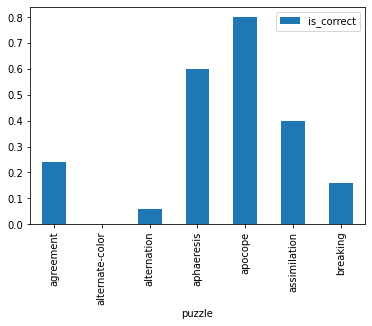

In [38]:
df.groupby('puzzle').mean().plot.bar()